In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [137]:
mesh = 46

In [138]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/xlabels.txt',delim_whitespace=True,header=None)



In [139]:

X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
# X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

           0         1         2         3        4        5         6  \
0    2.77049   5.32910   9.17043   7.23675  5.21731  32.2885  11.74730   
1    3.61746  12.72040  12.80220   8.35094  2.05551  39.2948  10.69220   
2    2.38790   7.65312  14.38840  10.16880  4.06018  28.3848  17.31130   
3    3.76219  21.59860  11.81960   3.56951  2.52663  18.8133  10.60980   
4    0.83687  10.96490   2.71685   3.73192  3.98974  30.5635   5.18740   
..       ...       ...       ...       ...      ...      ...       ...   
195  1.57167  20.55250   4.34630   4.02029  4.08107  32.4084  16.89020   
196  3.87212  31.39530   3.95767   9.41722  3.54334  16.8671  10.51070   
197  1.90693  19.14840   7.64500   4.70468  2.66861  22.9449  19.89110   
198  2.88270  17.37540  14.74540  10.00510  4.58641  27.4414   8.65209   
199  1.07599   4.21971   8.84592   3.88759  2.23291  12.5012  19.51450   

            7         8        9  
0    11.25900  0.013097  1.43362  
1    11.99220  0.004829  1.53001  
2    1

In [140]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/output_mask.txt',index_col=None,delim_whitespace=True,header=None)

In [141]:
np.sum(mask)

0    77
dtype: int64

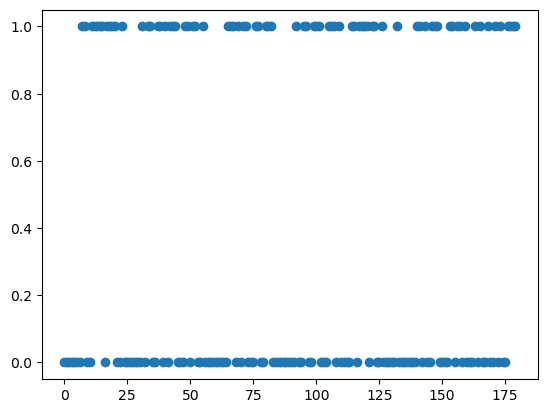

In [142]:
plt.plot(mask,'o')

In [143]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     $V^{\mathrm{max}}_{\mathrm{LV}}$  $V^{\mathrm{max}}_{\mathrm{RV}}$  \
0                               0.000                             0.000   
1                               0.000                             0.000   
2                               0.000                             0.000   
3                               0.000                             0.000   
4                               0.000                             0.000   
..                                ...                               ...   
175                             0.000                             0.000   
176                           131.914                           108.649   
177                           141.890                           112.490   
178                           137.761                           111.674   
179                           126.926                           108.653   

     $V^{\mathrm{max}}_{\mathrm{LA}}$  $V^{\mathrm{max}}_{\mathrm{RA}}$  \
0                       

In [144]:
input_masked = X_all.copy()

In [145]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_masked=input_masked.iloc[np.array(mask==1),]
y_all=y_all.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [146]:
input_masked.shape

(77, 10)

In [147]:
y_all.shape

(77, 10)

In [148]:
y_all.index[0]

7

In [149]:
y_all

,$V^{\mathrm{max}}_{\mathrm{LV}}$,$V^{\mathrm{max}}_{\mathrm{RV}}$,$V^{\mathrm{max}}_{\mathrm{LA}}$,$V^{\mathrm{max}}_{\mathrm{RA}}$,"$\overline{E_{ff,\mathrm{LV}}}$","$\overline{E_{ff,\mathrm{RV}}}$","$\overline{E_{ff,\mathrm{LA}}}$","$\overline{E_{ff,\mathrm{RA}}}$","$\overline{E_{ff,\mathrm{V}}}$","$\overline{E_{ff,\mathrm{A}}}$"
7,138.677,105.591,53.9261,34.7129,0.035854,0.013579,0.025043,0.000440,0.029149,0.009492
8,126.398,105.491,55.0379,35.1773,0.017763,0.008325,0.029339,0.002588,0.014913,0.012413
11,127.522,105.162,55.0749,35.0601,0.021611,0.008421,0.028798,0.002064,0.017634,0.011949
12,147.325,119.322,62.0395,37.3317,0.055556,0.027763,0.053458,0.010423,0.047097,0.026159
13,133.297,108.152,56.0817,35.5811,0.033253,0.011849,0.028963,0.003487,0.026781,0.012884
...,...,...,...,...,...,...,...,...,...,...
173,129.453,105.358,54.6755,35.0921,0.022367,0.009940,0.025434,0.001995,0.018624,0.010644
176,131.914,108.649,54.6627,35.3974,0.029003,0.012958,0.023188,0.002482,0.024150,0.010075
177,141.890,112.490,56.8956,35.7760,0.045011,0.019084,0.031668,0.004071,0.037169,0.014254
178,137.761,111.674,55.4408,35.6319,0.033134,0.015331,0.026640,0.003741,0.027727,0.012070


In [150]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [151]:
y_train

tensor([[ 1.3868e+02,  1.0559e+02,  5.3926e+01,  3.4713e+01,  3.5854e-02,
          1.3579e-02,  2.5043e-02,  4.4007e-04,  2.9149e-02,  9.4920e-03],
        [ 1.2640e+02,  1.0549e+02,  5.5038e+01,  3.5177e+01,  1.7763e-02,
          8.3246e-03,  2.9339e-02,  2.5876e-03,  1.4913e-02,  1.2413e-02],
        [ 1.2752e+02,  1.0516e+02,  5.5075e+01,  3.5060e+01,  2.1611e-02,
          8.4209e-03,  2.8798e-02,  2.0635e-03,  1.7634e-02,  1.1949e-02],
        [ 1.4732e+02,  1.1932e+02,  6.2039e+01,  3.7332e+01,  5.5556e-02,
          2.7763e-02,  5.3458e-02,  1.0423e-02,  4.7097e-02,  2.6159e-02],
        [ 1.3330e+02,  1.0815e+02,  5.6082e+01,  3.5581e+01,  3.3253e-02,
          1.1849e-02,  2.8963e-02,  3.4874e-03,  2.6781e-02,  1.2884e-02],
        [ 1.2682e+02,  1.0525e+02,  5.5444e+01,  3.4892e+01,  2.1401e-02,
          7.7855e-03,  3.6669e-02,  2.4042e-03,  1.7303e-02,  1.4931e-02],
        [ 1.3556e+02,  1.1169e+02,  5.8890e+01,  3.6441e+01,  3.1872e-02,
          1.4772e-02,  4.0052e-0

In [152]:
x_train.shape

torch.Size([77, 10])

In [153]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9


In [154]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[1.38606, 4.98092]
[2.00623, 31.6315]
[1.06893, 15.9664]
[1.32671, 11.908]
[1.54348, 5.99704]
[10.4491, 39.6406]
[5.23618, 19.5829]
[3.92921, 14.9855]
[0.000669586, 0.0493235]
[1.00128, 1.97786]


In [155]:
x_labels=[1,2,3,4,5,6,7,8,9,10]

In [156]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_1951/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [157]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

          ST   ST_conf
1   0.384346  0.036847
2   0.215067  0.029132
3   0.028673  0.003718
4   0.372562  0.040715
5   0.000193  0.000027
6   0.000034  0.000005
7   0.000492  0.000048
8   0.000119  0.000018
9   0.074839  0.007808
10  0.001284  0.000196
          S1   S1_conf
1   0.355823  0.044875
2   0.171722  0.039181
3   0.024113  0.015166
4   0.316640  0.046338
5   0.000108  0.001264
6   0.000054  0.000465
7   0.001439  0.001908
8   0.000693  0.001074
9   0.065119  0.024100
10  0.001064  0.002961
               S2   S2_conf
(1, 2)   0.004486  0.085534
(1, 3)   0.002516  0.074778
(1, 4)   0.010417  0.086272
(1, 5)   0.000405  0.072981
(1, 6)   0.000413  0.073175
(1, 7)   0.000590  0.073241
(1, 8)   0.000461  0.073219
(1, 9)   0.000954  0.078041
(1, 10)  0.000116  0.073168
(2, 3)  -0.001496  0.059500
(2, 4)   0.032661  0.083927
(2, 5)   0.000770  0.060646
(2, 6)   0.000778  0.060798
(2, 7)  -0.000211  0.061034
(2, 8)   0.000326  0.060852
(2, 9)   0.005258  0.059182
(2, 10)  0.000479 

          ST   ST_conf
1   0.002536  0.000298
2   0.000532  0.000077
3   0.001080  0.000115
4   0.011462  0.001386
5   0.491917  0.048698
6   0.292339  0.030792
7   0.001903  0.000232
8   0.053035  0.005989
9   0.187057  0.021965
10  0.002493  0.000518
          S1   S1_conf
1   0.002712  0.003968
2  -0.000438  0.001976
3   0.000954  0.003014
4   0.009526  0.009368
5   0.463213  0.052206
6   0.267940  0.046095
7   0.001278  0.003678
8   0.044588  0.018959
9   0.165996  0.046420
10  0.000096  0.003959
               S2   S2_conf
(1, 2)  -0.000345  0.004967
(1, 3)  -0.000398  0.004969
(1, 4)  -0.000364  0.004979
(1, 5)   0.000355  0.006758
(1, 6)  -0.000162  0.005900
(1, 7)  -0.000299  0.004963
(1, 8)  -0.000954  0.004912
(1, 9)  -0.000925  0.005674
(1, 10) -0.000425  0.005015
(2, 3)   0.000905  0.002635
(2, 4)   0.000939  0.002641
(2, 5)   0.000871  0.003137
(2, 6)   0.000318  0.002882
(2, 7)   0.000889  0.002651
(2, 8)   0.000840  0.002644
(2, 9)   0.001155  0.002953
(2, 10)  0.000849 

In [158]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [159]:
# x_labels.values.squeeze().tolist()

In [160]:
y_all.columns.tolist()

['$V^{\\mathrm{max}}_{\\mathrm{LV}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{RV}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{LA}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{RA}}$',
 '$\\overline{E_{ff,\\mathrm{LV}}}$',
 '$\\overline{E_{ff,\\mathrm{RV}}}$',
 '$\\overline{E_{ff,\\mathrm{LA}}}$',
 '$\\overline{E_{ff,\\mathrm{RA}}}$',
 '$\\overline{E_{ff,\\mathrm{V}}}$',
 '$\\overline{E_{ff,\\mathrm{A}}}$']

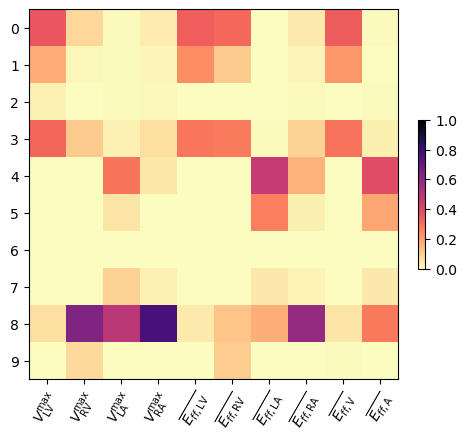

In [161]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

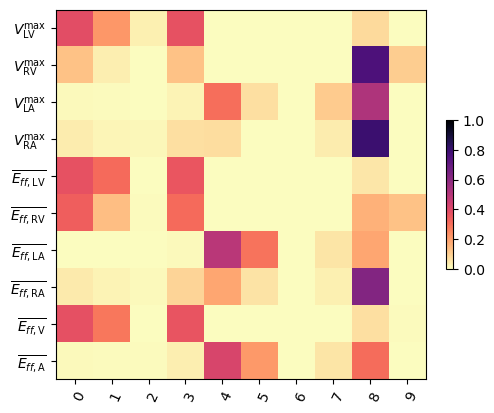

In [162]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [163]:
np.savetxt("Si_total_mech_"+str(mesh)+".csv", Si_total, delimiter=",")
np.savetxt("Si_first_mech_"+str(mesh)+".csv", Si_first, delimiter=",")